In [ ]:
!pip install snntorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.2/125.2 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.2/76.2 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 918.1 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━

In [ ]:
# imports
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
import itertools

In [ ]:
# dataloader arguments
batch_size = 128
data_path='/tmp/data/mnist'

dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
# Define a transform
transform = transforms.Compose([
            transforms.Resize((28, 28)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(data_path, train=False, download=True, transform=transform)

100%|██████████| 9912422/9912422 [00:00<00:00, 86610291.07it/s]


Extracting /tmp/data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to /tmp/data/mnist/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 9132666.90it/s]


Extracting /tmp/data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to /tmp/data/mnist/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 29429826.03it/s]


Extracting /tmp/data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to /tmp/data/mnist/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 11774121.61it/s]

Extracting /tmp/data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to /tmp/data/mnist/MNIST/raw



In [ ]:
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=True)

In [ ]:
# Network Architecture
num_inputs = 28*28
num_hidden = 1000
num_outputs = 10

# Temporal Dynamics
num_steps = 25
beta = 0.95

In [ ]:
# Define Network
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        # Initialize layers
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Leaky(beta=beta)
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.Leaky(beta=beta)

    def forward(self, x):

        # Initialize hidden states at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()

        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        for step in range(num_steps):
            cur1 = self.fc1(x)
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)

# Load the network onto CUDA if available
net = Net().to(device)

In [ ]:
# pass data into the network, sum the spikes over time
# and compare the neuron with the highest number of spikes
# with the target

def print_batch_accuracy(data, targets, train=False):
    output, _ = net(data.view(batch_size, -1))
    _, idx = output.sum(dim=0).max(1)
    acc = np.mean((targets == idx).detach().cpu().numpy())

    if train:
        print(f"Train set accuracy for a single minibatch: {acc*100:.2f}%")
    else:
        print(f"Test set accuracy for a single minibatch: {acc*100:.2f}%")

def train_printer(
    data, targets, epoch,
    counter, iter_counter,
        loss_hist, test_loss_hist, test_data, test_targets):
    print(f"Epoch {epoch}, Iteration {iter_counter}")
    print(f"Train Set Loss: {loss_hist[counter]:.2f}")
    print(f"Test Set Loss: {test_loss_hist[counter]:.2f}")
    print_batch_accuracy(data, targets, train=True)
    print_batch_accuracy(test_data, test_targets, train=False)
    print("\n")

In [ ]:
loss = nn.CrossEntropyLoss()

In [ ]:
optimizer = torch.optim.Adam(net.parameters(), lr=5e-4, betas=(0.9, 0.999))

In [ ]:
data, targets = next(iter(train_loader))
data = data.to(device)
targets = targets.to(device)

In [ ]:
spk_rec, mem_rec = net(data.view(batch_size, -1))
print(mem_rec.size())

torch.Size([25, 128, 10])


In [ ]:
# initialize the total loss value
loss_val = torch.zeros((1), dtype=dtype, device=device)

# sum loss at every step
for step in range(num_steps):
  loss_val += loss(mem_rec[step], targets)

print(f"Training loss: {loss_val.item():.3f}")

Training loss: 59.638


In [ ]:
print_batch_accuracy(data, targets, train=True)

Train set accuracy for a single minibatch: 8.59%


In [ ]:
# clear previously stored gradients
optimizer.zero_grad()

# calculate the gradients
loss_val.backward()

# weight update
optimizer.step()

In [ ]:
# calculate new network outputs using the same data
spk_rec, mem_rec = net(data.view(batch_size, -1))

# initialize the total loss value
loss_val = torch.zeros((1), dtype=dtype, device=device)

# sum loss at every step
for step in range(num_steps):
  loss_val += loss(mem_rec[step], targets)

print(f"Training loss: {loss_val.item():.3f}")
print_batch_accuracy(data, targets, train=True)

Training loss: 50.385
Train set accuracy for a single minibatch: 58.59%


In [ ]:
num_epochs = 1
loss_hist = []
test_loss_hist = []
counter = 0

# Outer training loop
for epoch in range(num_epochs):
    iter_counter = 0
    train_batch = iter(train_loader)

    # Minibatch training loop
    for data, targets in train_batch:
        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        net.train()
        spk_rec, mem_rec = net(data.view(batch_size, -1))

        # initialize the loss & sum over time
        loss_val = torch.zeros((1), dtype=dtype, device=device)
        for step in range(num_steps):
            loss_val += loss(mem_rec[step], targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        # Test set
        with torch.no_grad():
            net.eval()
            test_data, test_targets = next(iter(test_loader))
            test_data = test_data.to(device)
            test_targets = test_targets.to(device)

            # Test set forward pass
            test_spk, test_mem = net(test_data.view(batch_size, -1))

            # Test set loss
            test_loss = torch.zeros((1), dtype=dtype, device=device)
            for step in range(num_steps):
                test_loss += loss(test_mem[step], test_targets)
            test_loss_hist.append(test_loss.item())

            # Print train/test loss/accuracy
            if counter % 50 == 0:
                train_printer(
                    data, targets, epoch,
                    counter, iter_counter,
                    loss_hist, test_loss_hist,
                    test_data, test_targets)
            counter += 1
            iter_counter +=1

Epoch 0, Iteration 0
Train Set Loss: 52.26
Test Set Loss: 48.39
Train set accuracy for a single minibatch: 68.75%
Test set accuracy for a single minibatch: 61.72%


Epoch 0, Iteration 50
Train Set Loss: 10.15
Test Set Loss: 12.51
Train set accuracy for a single minibatch: 89.06%
Test set accuracy for a single minibatch: 85.94%


Epoch 0, Iteration 100
Train Set Loss: 9.79
Test Set Loss: 10.19
Train set accuracy for a single minibatch: 87.50%
Test set accuracy for a single minibatch: 90.62%


Epoch 0, Iteration 150
Train Set Loss: 9.08
Test Set Loss: 7.42
Train set accuracy for a single minibatch: 92.19%
Test set accuracy for a single minibatch: 90.62%


Epoch 0, Iteration 200
Train Set Loss: 9.30
Test Set Loss: 7.93
Train set accuracy for a single minibatch: 90.62%
Test set accuracy for a single minibatch: 85.16%


Epoch 0, Iteration 250
Train Set Loss: 7.48
Test Set Loss: 8.13
Train set accuracy for a single minibatch: 92.19%
Test set accuracy for a single minibatch: 88.28%




In [ ]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(loss_hist)
plt.plot(test_loss_hist)
plt.title("Loss Curves")
plt.legend(["Train Loss", "Test Loss"])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

In [ ]:
total = 0
correct = 0

# drop_last switched to False to keep all samples
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=False)

with torch.no_grad():
  net.eval()
  for data, targets in test_loader:
    data = data.to(device)
    targets = targets.to(device)

    # forward pass
    test_spk, _ = net(data.view(data.size(0), -1))

    # calculate total accuracy
    _, predicted = test_spk.sum(dim=0).max(1)
    total += targets.size(0)
    correct += (predicted == targets).sum().item()

print(f"Total correctly classified test set images: {correct}/{total}")
print(f"Test Set Accuracy: {100 * correct / total:.2f}%")

In [ ]:
layers = []
for layer in net.children():
    if isinstance(layer, nn.Linear):
        layers.append(layer.state_dict()['weight'])

print(layers[0])
print(layers[1])

In [ ]:
print("Dimensions of the first layer:")
print(f"  Number of rows: {layers[0].shape[0]}")
print(f"  Number of columns: {layers[0].shape[1]}")

# Print the dimensions of the second layer
print("\nDimensions of the second layer:")
print(f"  Number of rows: {layers[1].shape[0]}")
print(f"  Number of columns: {layers[1].shape[1]}")

This is provided in SNN Tutorial 3, but we know that here columns is the source, and rows are the target.

In [ ]:
layer1=layers[0]
layer2=layers[1]

In [ ]:
import networkx as nx

# Create separate lists for source and target nodes
source_node_labels = [f"{0}:{j}" for j in range(layer1.shape[1])]
middle_node_labels = [f"{1}:{j}" for j in range(layer1.shape[0])]
target_node_labels = [f"{2}:{j}" for j in range(layer2.shape[0])]

#print(source_node_labels)
#print(middle_node_labels)
#print(target_node_labels)

G = nx.Graph()

G.add_nodes_from(source_node_labels, bipartite=0)
G.add_nodes_from(middle_node_labels, bipartite=1)
G.add_nodes_from(target_node_labels, bipartite=2)

#print(G)

In [ ]:
# Add weighted edges
for i in range(layer1.shape[0]):
    # Loop through the columns of the random_array
    for j in range(layer1.shape[1]):
        # Get the corresponding node labels
        source_node = source_node_labels[j]
        middle_node = middle_node_labels[i]

        # Add an edge between the nodes with the weight from the random_array
        G.add_edge(source_node, middle_node, weight=layer1[i][j])

for i in range(layer2.shape[0]):
    # Loop through the columns of the random_array
    for j in range(layer2.shape[1]):
        # Get the corresponding node labels
        middle_node = middle_node_labels[j]
        target_node = target_node_labels[i]

        # Add an edge between the nodes with the weight from the random_array
        G.add_edge(middle_node, target_node, weight=layer2[i][j])

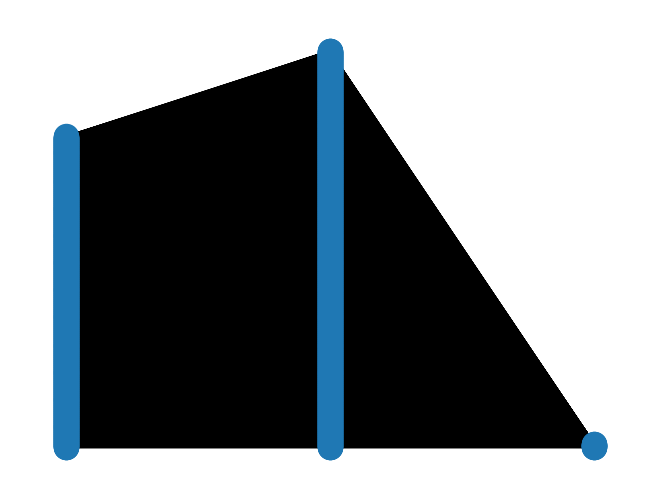

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms import bipartite

pos = dict()
pos.update( (n, (0, i)) for i, n in enumerate(source_node_labels) ) # put nodes from X at x=1
pos.update( (n, (1, i)) for i, n in enumerate(middle_node_labels) ) # put nodes from Y at x=2
pos.update( (n, (2, i)) for i, n in enumerate(target_node_labels) ) # put nodes from Y at x=3
nx.draw(G, pos=pos)
plt.show()

In [ ]:
# Get all edge attributes
edge_attributes = nx.get_edge_attributes(G, 'weight')

# Print the edge attributes
print(edge_attributes)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

